<a href="https://colab.research.google.com/github/AnantChandra/google-colab/blob/main/rohlik_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anantchandra","key":"0d4a00a1837c8993c7fc12089269e19e"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c rohlik-sales-forecasting-challenge-v2

 95% 45.0M/47.3M [00:02<00:00, 23.5MB/s]
100% 47.3M/47.3M [00:02<00:00, 18.7MB/s]


In [5]:
!unzip rohlik-sales-forecasting-challenge-v2.zip

Archive:  rohlik-sales-forecasting-challenge-v2.zip
  inflating: calendar.csv            
  inflating: inventory.csv           
  inflating: sales_test.csv          
  inflating: sales_train.csv         
  inflating: solution.csv            
  inflating: test_weights.csv        


In [6]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns

In [7]:
sales_train = pd.read_csv('sales_train.csv', parse_dates=['date'])
sales_test = pd.read_csv('sales_test.csv', parse_dates=['date'])
inventory = pd.read_csv('inventory.csv')
calendar = pd.read_csv('calendar.csv', parse_dates=['date'])
test_weights = pd.read_csv('test_weights.csv')
solution = pd.read_csv('solution.csv')

In [8]:
sales_train = pd.merge(sales_train, inventory, how='left', on =['unique_id','warehouse'])
sales_test = pd.merge(sales_test, inventory, how='left', on =['unique_id','warehouse'])

In [9]:
for df in [sales_train,sales_test]:
    df.set_index('date',inplace=True)

In [10]:
np.setdiff1d(sales_train.columns, sales_test.columns)

array(['availability', 'sales'], dtype=object)

In [11]:
sales_train.drop(['availability'], axis=1, inplace=True)
sales_train.sort_values(['date','warehouse'], inplace=True)

In [12]:
from scipy.stats import kurtosis

In [13]:
result = sales_train.reset_index().groupby(['warehouse']).agg(
    count = ('date','size'),
    first_date = ('date','min'),
    last_date = ('date','max'),
    date_difference=('date', lambda x: x.max() - x.min()),
    var_sales = ('sell_price_main','var'),
    mean_price = ('sell_price_main','mean'),
    skew_price = ('sell_price_main','skew'),
    max_price = ('sell_price_main','max'),
    kurtosis_sales = ('sell_price_main',kurtosis)
)

In [14]:
result

,count,first_date,last_date,date_difference,var_sales,mean_price,skew_price,max_price,kurtosis_sales
warehouse,,,,,,,,,
Brno_1,643637,2020-08-01,2024-06-02,1401 days,5108.657471,67.873869,2.826800,1015.51,11.636842
Budapest_1,574582,2020-08-01,2024-06-02,1401 days,822068.394919,918.184147,4.306405,21682.99,34.278188
Frankfurt_1,198937,2021-12-08,2024-06-02,907 days,10.047742,2.977863,6.456303,50.15,69.010019
Munich_1,259333,2021-05-20,2024-06-02,1109 days,7.316594,3.002412,4.059457,38.75,33.219987
Prague_1,780566,2020-08-01,2024-06-02,1401 days,4496.440265,65.941507,2.614916,1112.54,9.307276
Prague_2,770709,2020-08-01,2024-06-02,1401 days,4287.697391,65.624530,2.540218,994.18,8.578498
Prague_3,779655,2020-08-01,2024-06-02,1401 days,4970.689358,67.141527,2.560767,963.01,8.294052


In [15]:
result = sales_test.reset_index().groupby(['warehouse']).agg(
    count = ('date','size'),
    first_date = ('date','min'),
    last_date = ('date','max'),
    date_difference= ('date', lambda x: (x.max() - x.min()).days+1)
)

In [16]:
result

,count,first_date,last_date,date_difference
warehouse,,,,
Brno_1,7196,2024-06-03,2024-06-16,14
Budapest_1,6576,2024-06-03,2024-06-16,14
Frankfurt_1,3222,2024-06-03,2024-06-16,14
Munich_1,3907,2024-06-03,2024-06-16,14
Prague_1,8714,2024-06-03,2024-06-16,14
Prague_2,8655,2024-06-03,2024-06-16,14
Prague_3,8751,2024-06-03,2024-06-16,14


In [17]:
del result

In [18]:
u_warehouses = sales_train['warehouse'].unique()

In [19]:
!pip install colorama
from colorama import Style, Fore

for w in u_warehouses:
    missing = pd.date_range(
        start=sales_train.loc[sales_train.warehouse==w].index.min(),
        end=sales_train.loc[sales_train.warehouse==w].index.max()
        ).difference(sales_train.loc[sales_train.warehouse==w].index)

    if missing.size > 0:
        print(f'{Style.BRIGHT}{Fore.BLUE}**{w}**{Style.RESET_ALL}')
        first_date = sales_train.loc[sales_train.warehouse==w].index.min().strftime("%Y-%m-%d")
        last_date  = sales_train.loc[sales_train.warehouse==w].index.max().strftime("%Y-%m-%d")
        print(f'{Style.BRIGHT}{Fore.YELLOW} Missing Dates-> {Style.RESET_ALL}{pd.date_range(start=sales_train.loc[sales_train.warehouse==w].index.min(),end=sales_train.loc[sales_train.warehouse==w].index.max()).difference(sales_train.loc[sales_train.warehouse==w].index)}\n')

**Munich_1**
 Missing Dates-> DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-05', '2021-06-06', '2021-06-07', '2021-06-08'],
              dtype='datetime64[ns]', freq='D')

**Frankfurt_1**
 Missing Dates-> DatetimeIndex(['2021-12-11', '2021-12-12', '2021-12-13', '2021-12-14',
               '2021-12-15', '2021-12-16', '2021-12-17', '2021-12-18',
               '2021-12-19', '2021-12-20', '2021-12-21', '2021-12-22',
               '2021-12-23', '2021-12-24', '2021-12-25', '2021-12-26',
               '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30',
               '2021-12-31', '2022-01-01', '2022-01-02', '2022-01-03',
               '2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07',
               '2022-01-08', '2022-01-09', '2022-01-10', '2022-01-11',
               '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-15',
               '2022-01-16', '2022-01-17', '2022-01-18', '2022-01-19',
               '2022-01-20', '2022-

In [20]:
sales_train[sales_train.sales.isnull()]['warehouse'].value_counts()

,count
warehouse,
Munich_1,46
Frankfurt_1,6


In [21]:
cat_cols = list(sales_test.select_dtypes(include='O'))
num_cols = list(sales_test._get_numeric_data())
target = 'sales'
initial_features = list(sales_test.columns)

In [22]:
for c in cat_cols:
    A = sales_train[c].fillna('None').astype(str).unique()
    B = sales_test[c].fillna('None').astype(str).unique()
    C = np.setdiff1d(B,A)
    if C.size>0:
        print(C)
        sales_train.iloc[~sales_train[c].isin(C), c ] = 'None'
    sales_train[c] = sales_train[c].astype('category')
    sales_test[c] = sales_test[c].astype('category')

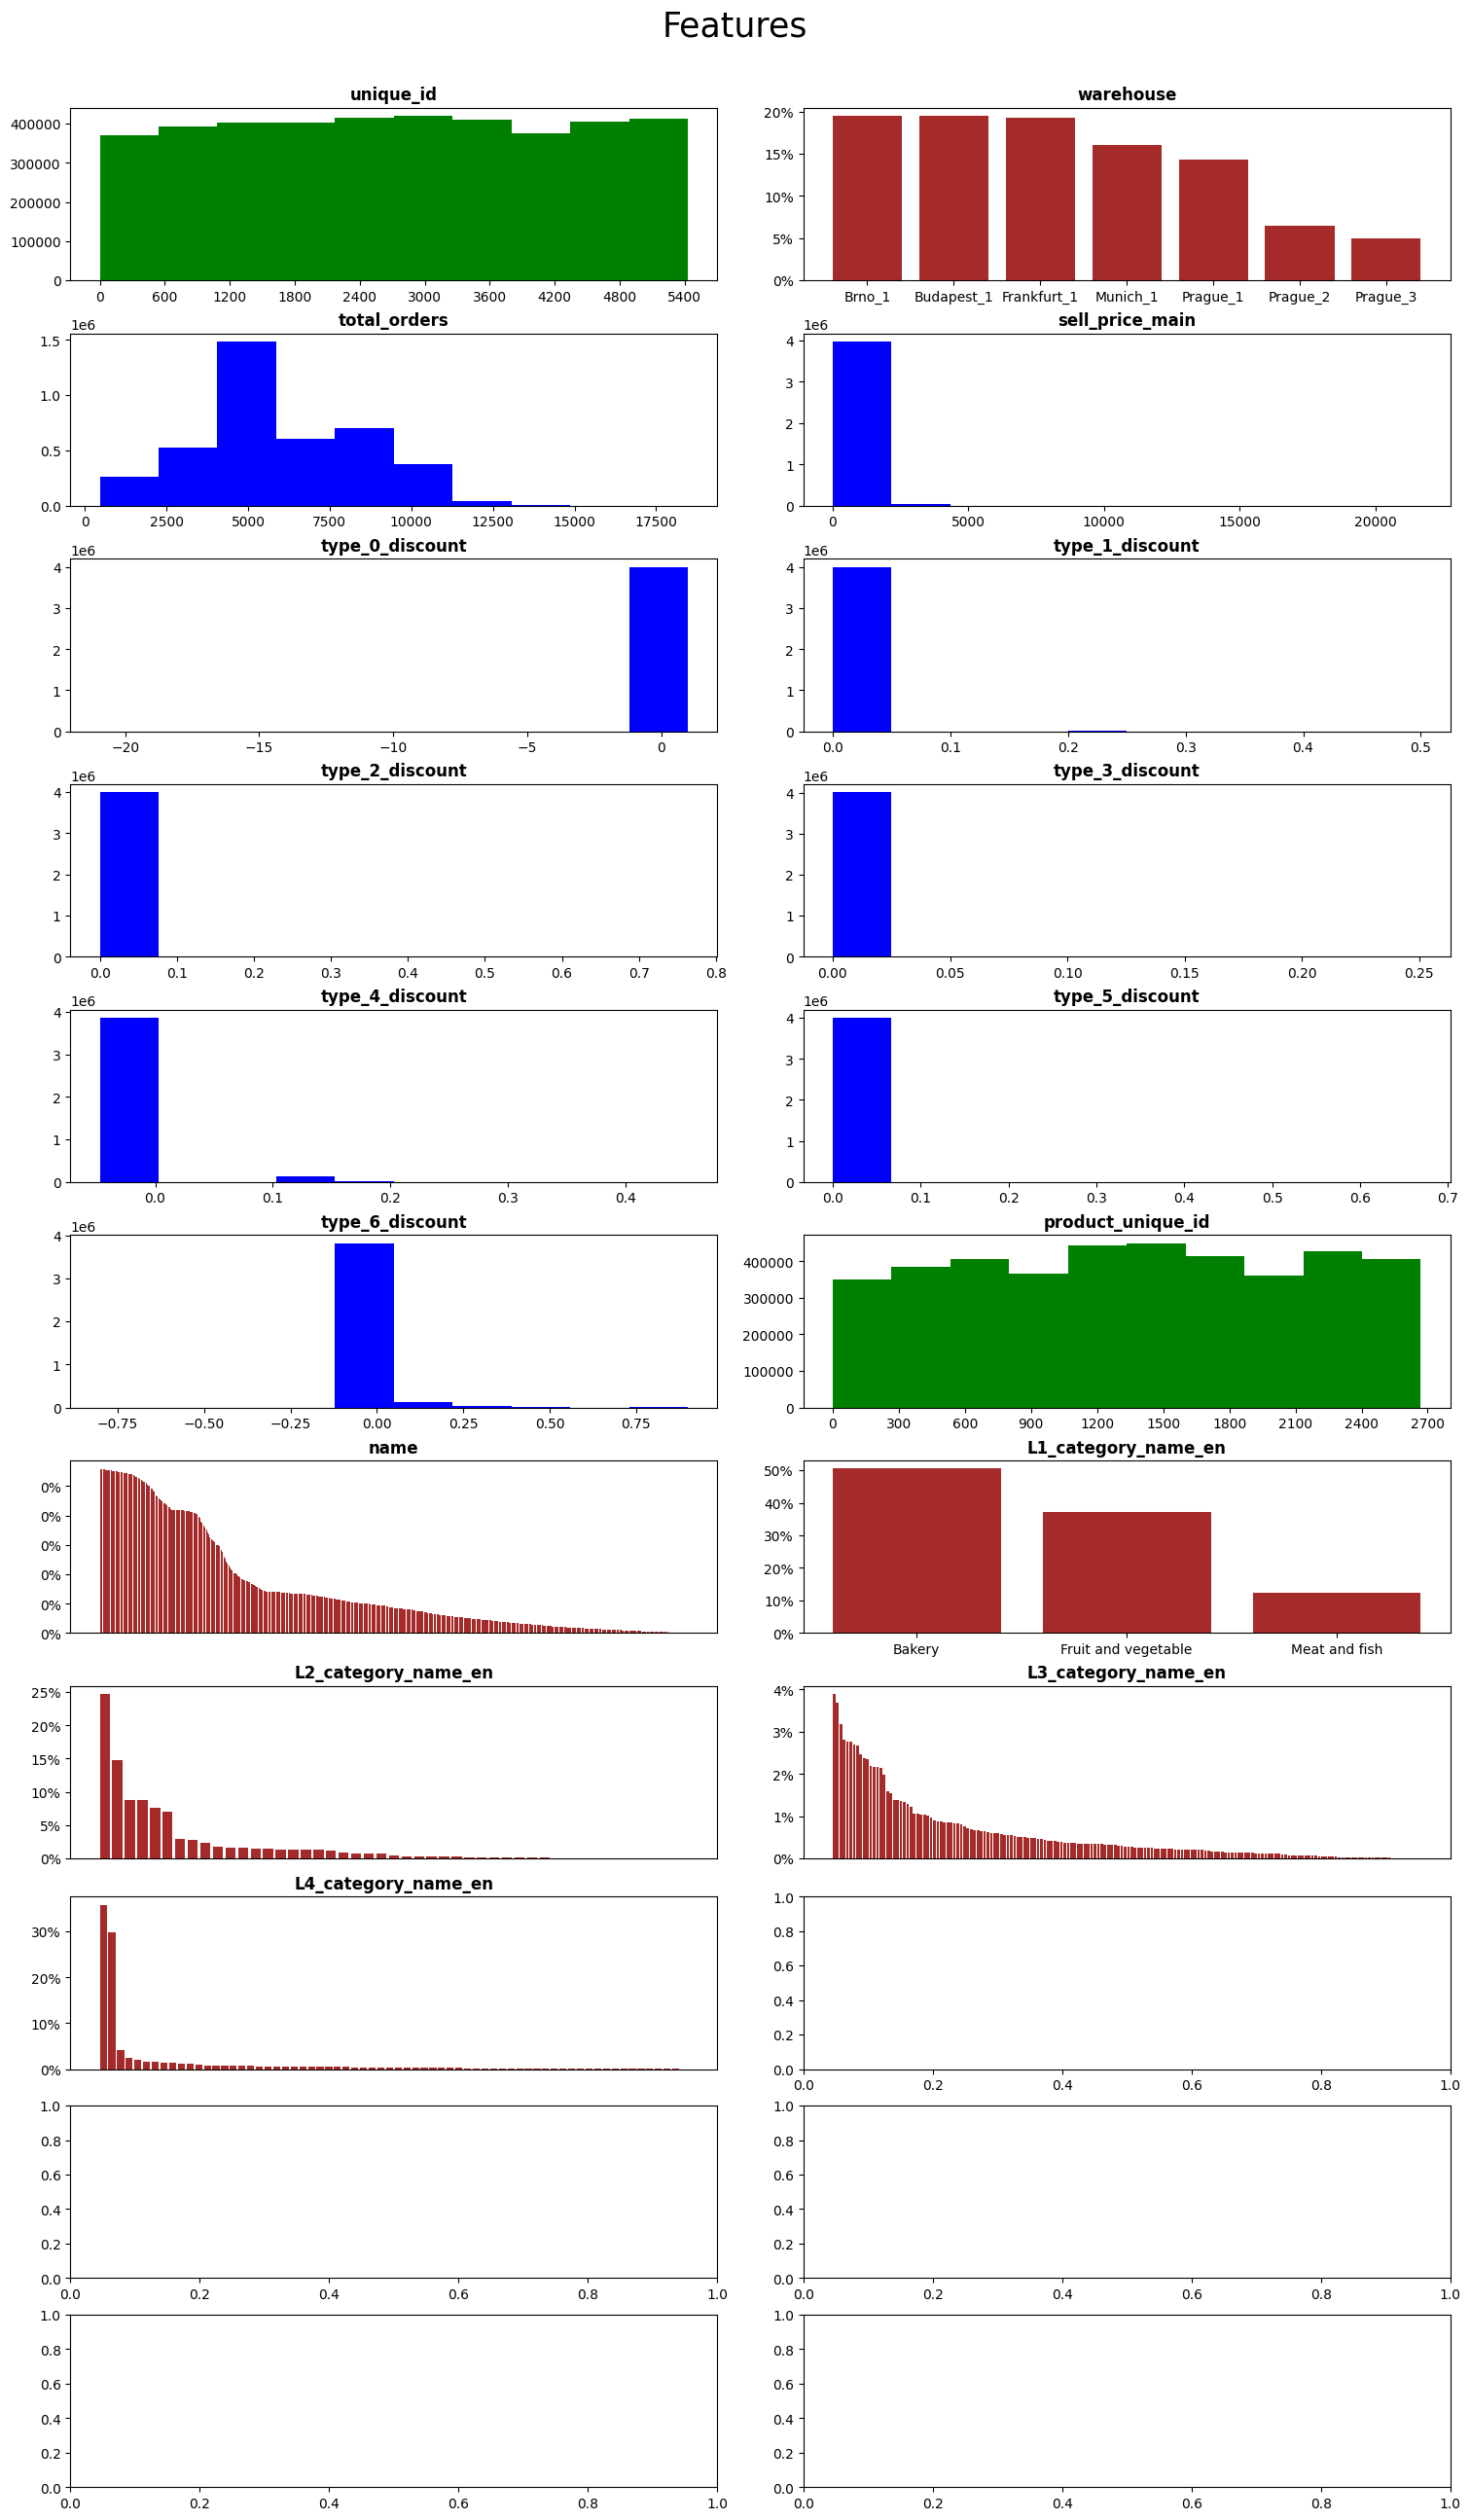

In [23]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, axs= plt.subplots(11,2, figsize=(15,25),  constrained_layout=True)
for c, ax in zip(initial_features, axs.ravel()):
    if sales_train[c].dtype=='float':
        ax.hist(sales_train[c],color='blue')
    elif sales_train[c].dtype=='category':
        vc = sales_train[c].value_counts() / len(sales_train)
        ax.bar(vc.index,vc, color='brown')
        ax.yaxis.set_major_formatter('{x:.0%}')
        if len(vc)<=15:
            ax.set_xticks(np.arange(len(sales_train[c].dtype.categories)), sales_train[c].dtype.categories)
            ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
        else:
            ax.set_xticks([])
    elif sales_train[c].dtype=='int64':
        ax.hist(sales_train[c],color='green')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax.set_title(f'{c}', fontweight='bold')
#axs.flat[-1].set_visible(False)
plt.suptitle('Features', y=1.03, fontsize=25);

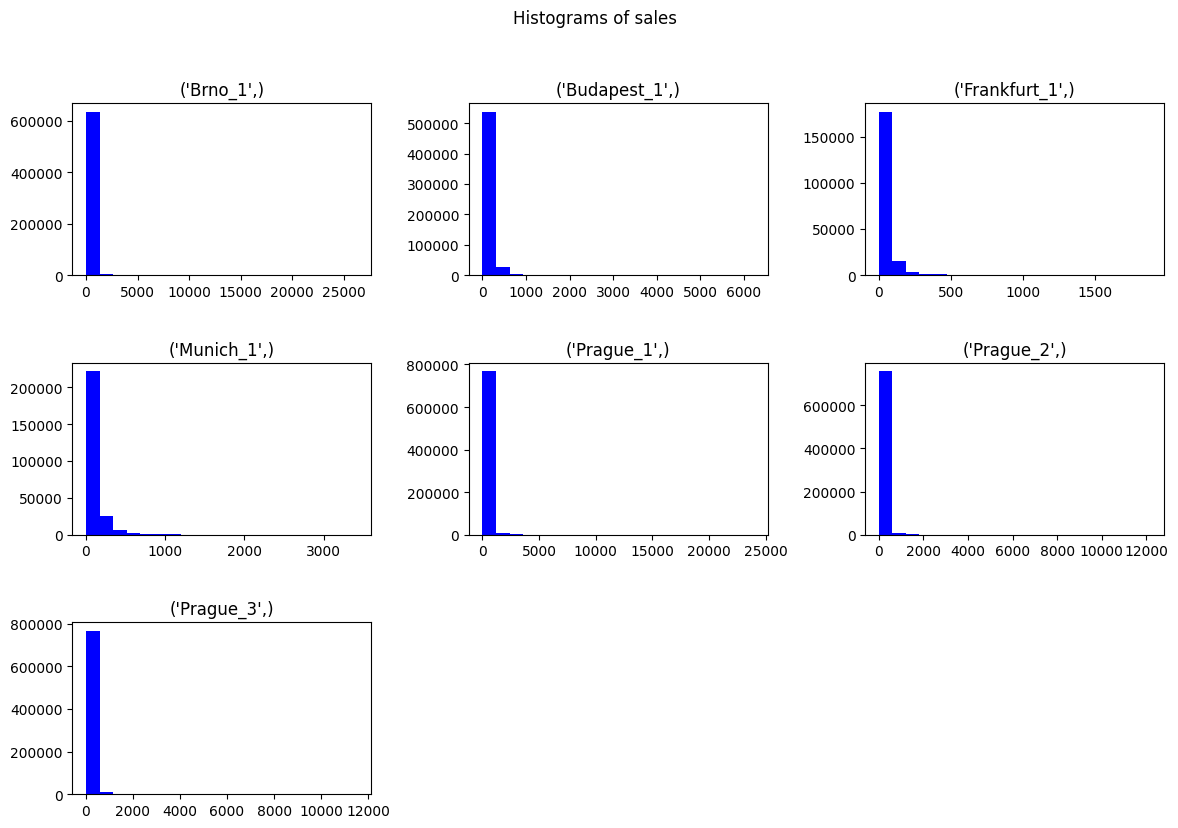

In [24]:
plt.figure(figsize=(12, 8))
for i, (combi, df) in enumerate(sales_train.groupby(['warehouse'],observed=False)):
    ax = plt.subplot(3, 3, i+1)
    ax.hist(df.sales, bins=20, color='blue')
    ax.set_title(combi)
plt.suptitle('Histograms of sales', y=1.03)
plt.tight_layout(h_pad=3.0)
plt.show()

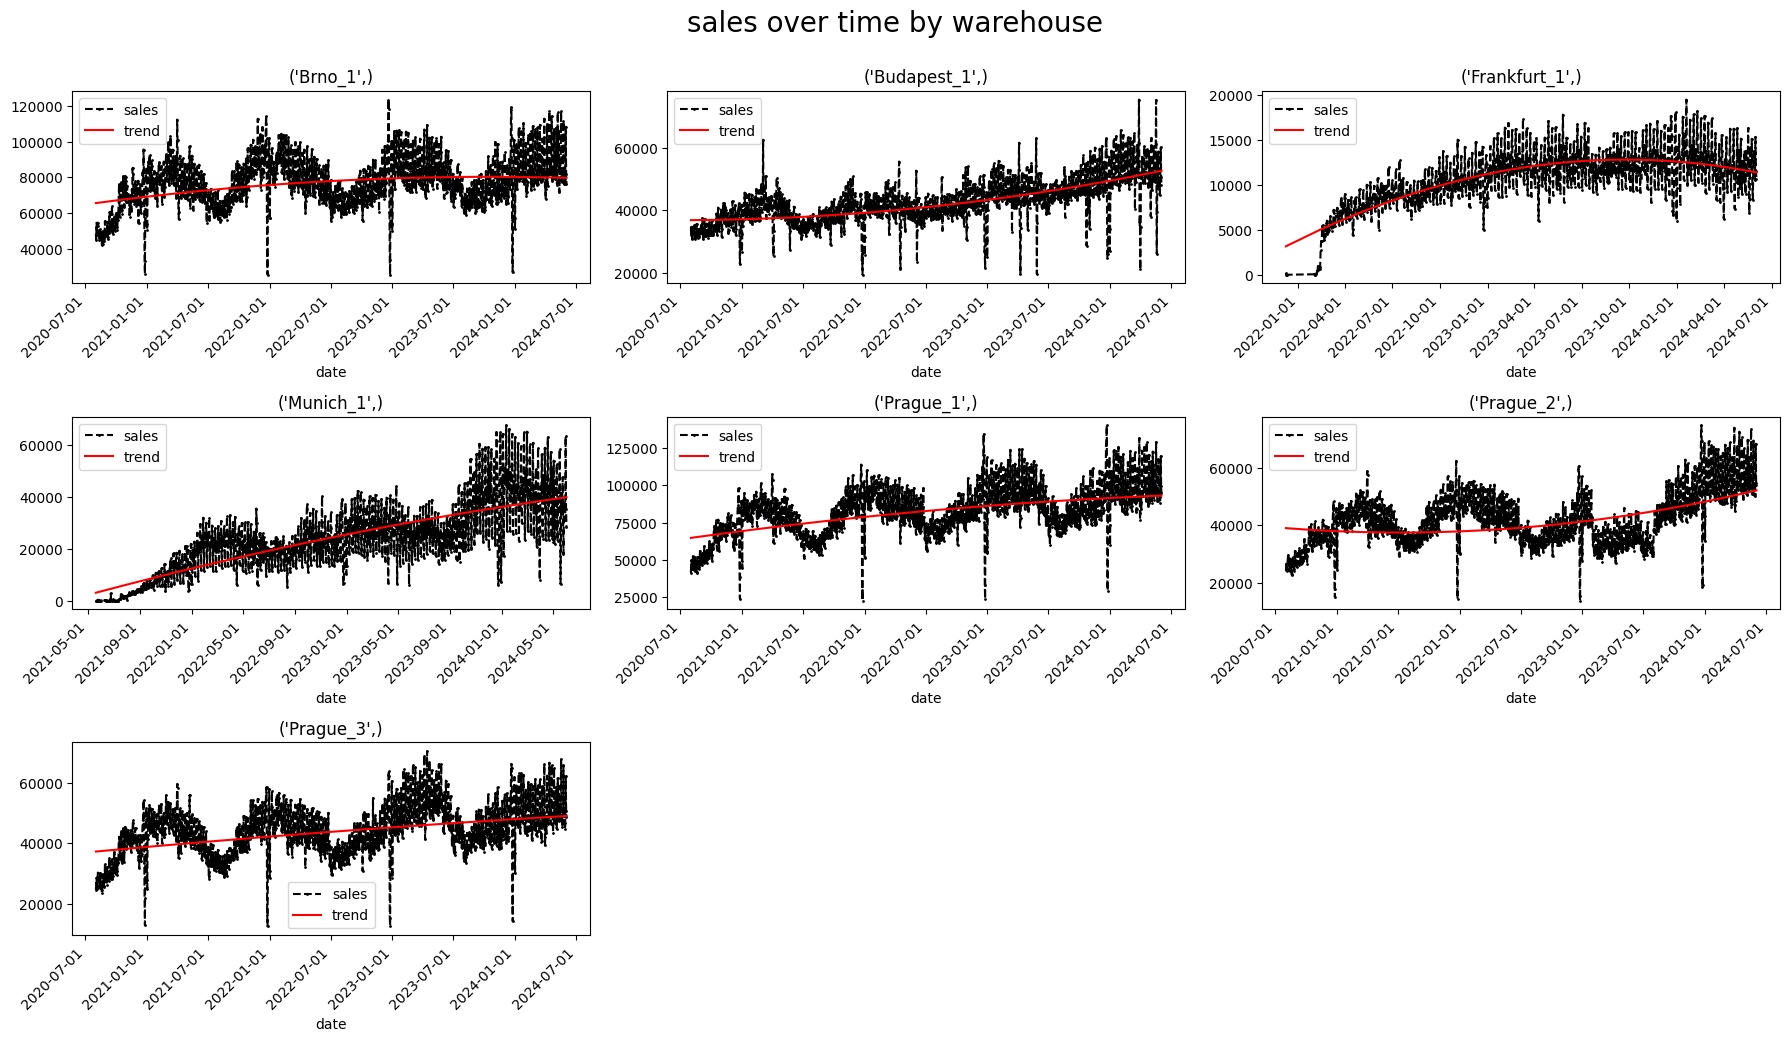

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

plt.figure(figsize=(18,22))
for i, (comb, df) in enumerate(sales_train.groupby(['warehouse'], observed=False)):
    ax = plt.subplot(7,3, i+1)
    sales = df.sort_values(by='date').groupby('date')['sales'].sum().reset_index()
    trend = (sales.date - sales.iloc[0].date) // dt.timedelta(days=1)
    trend = trend.values.reshape(-1,1)
    model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
    model.fit(trend,sales.sales)
    y_pred = pd.Series(model.predict(trend), index=sales.date)

    ax.plot(sales.date,sales.sales,label='sales', color='black',marker='o',ls='--',markersize=1)
    y_pred.plot(ax=ax,color='red',label='trend')
    ax.set_title(comb)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    ax.legend()


plt.tight_layout()
plt.suptitle('sales over time by warehouse',fontsize=20,y=1.02)
plt.show()

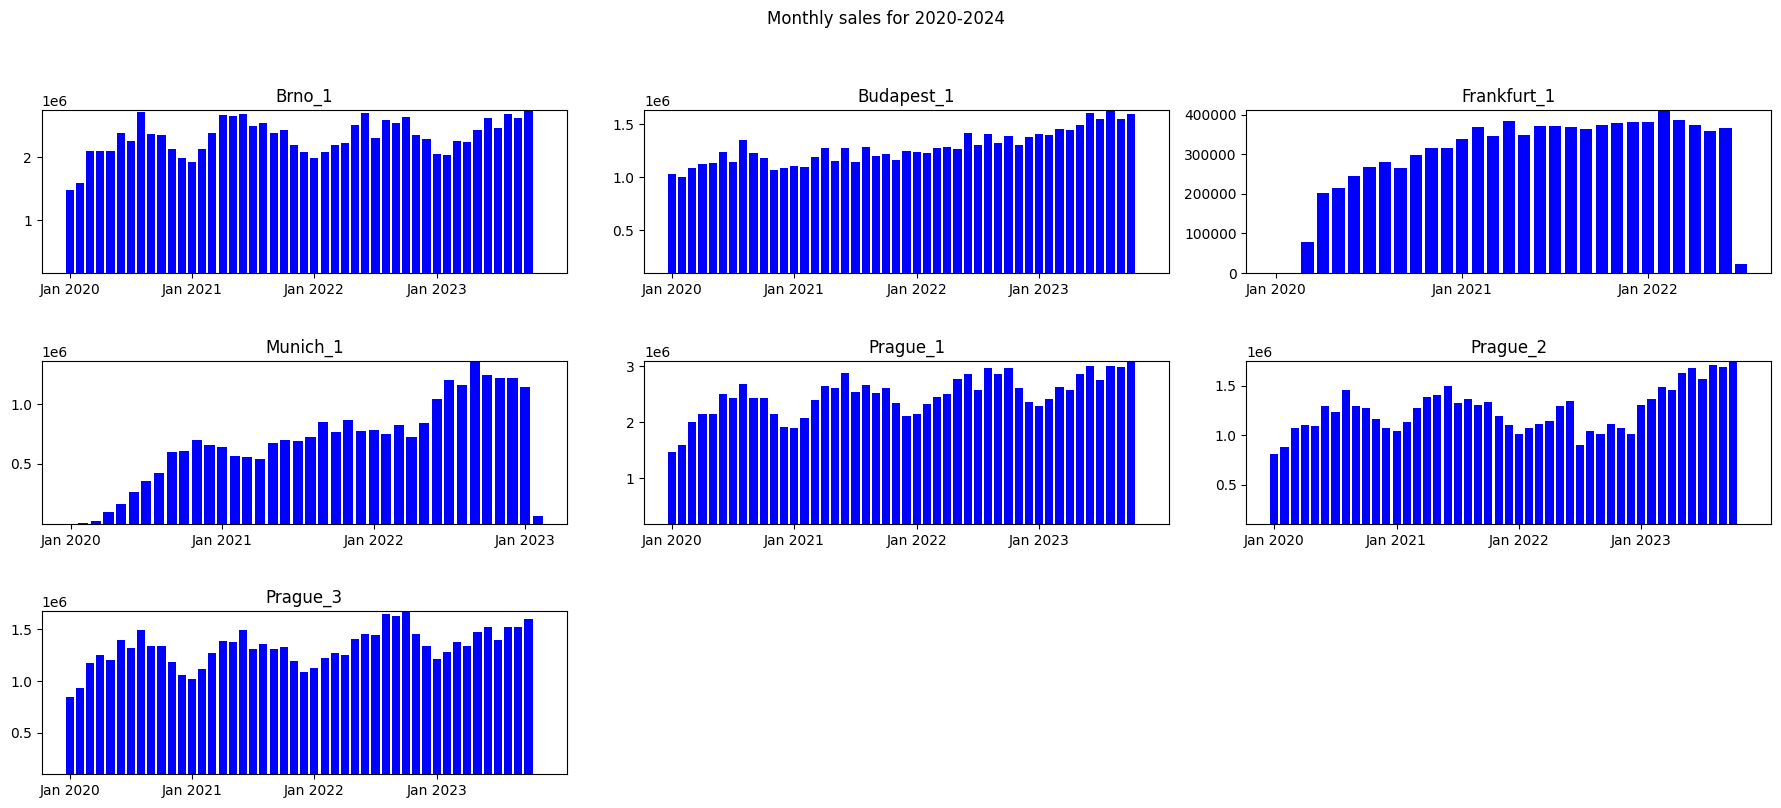

In [26]:
plt.figure(figsize=(18,10))
for i, (comb, df) in enumerate(sales_train.groupby(sales_train.warehouse,observed=False)):
    ax = plt.subplot(4, 3, i+1, ymargin=0.5)

    resampled = df.resample('MS').sales.sum()
    colors = ['blue'] * len(resampled)
    ax.set_title(comb)
    ax.set_ylim(resampled.min(), resampled.max())
    ax.bar(range(len(resampled)), resampled)
    ax.set_xticks(range(0, 48, 12), [f"Jan {y}" for y in range(2020, 2024)])
    ax.bar(range(len(resampled)), resampled, color=colors)

plt.suptitle('Monthly sales for 2020-2024', y=1.03)
plt.tight_layout(h_pad=3.0)
plt.show()

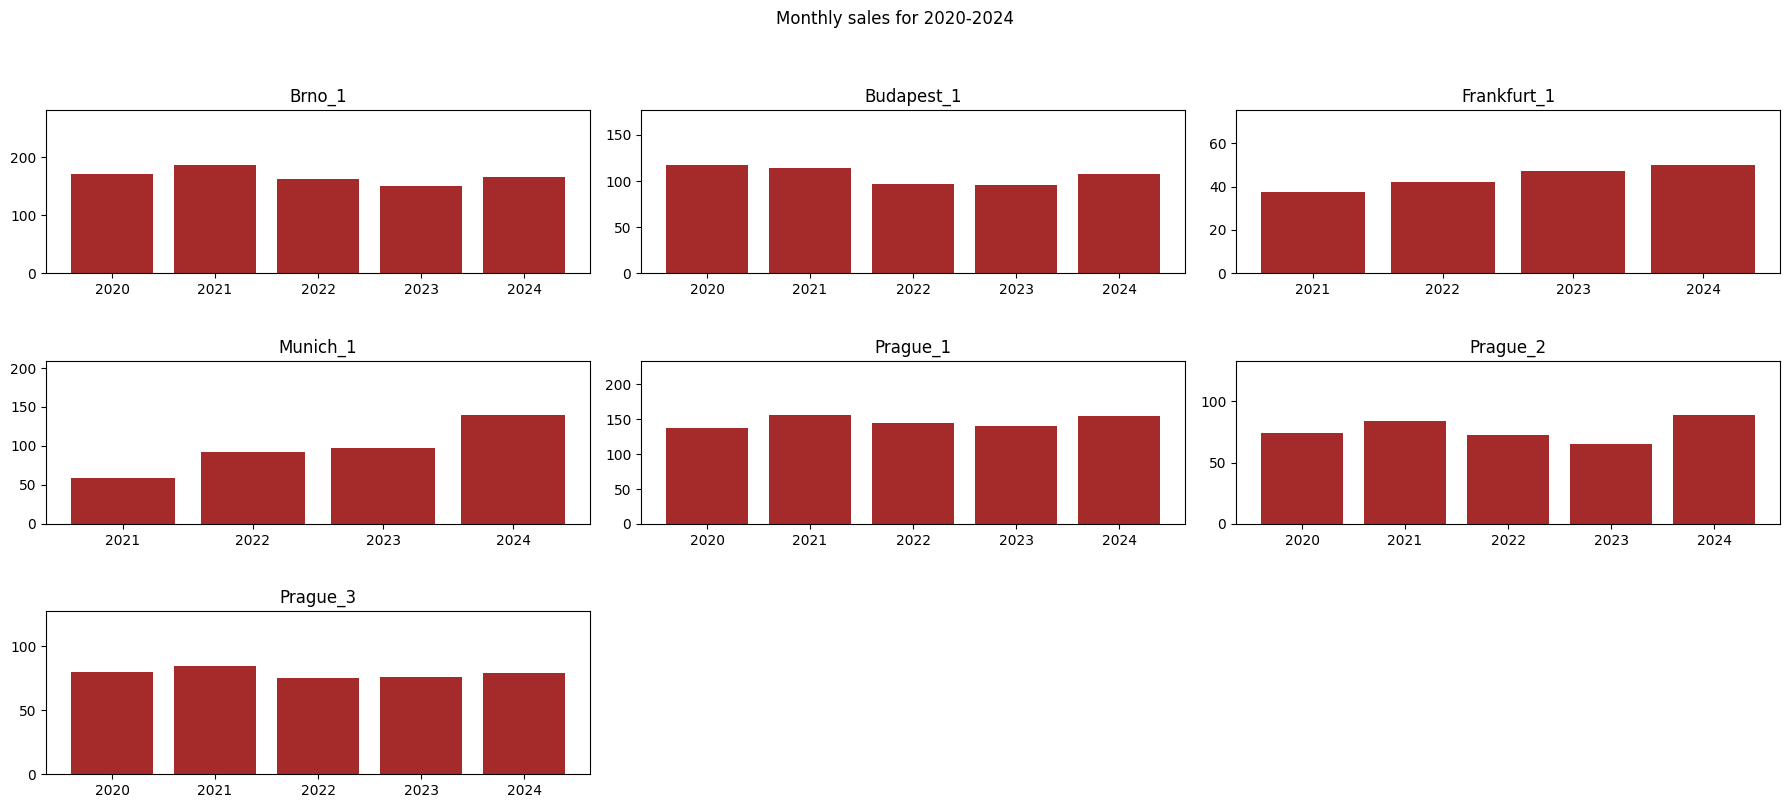

In [28]:
plt.figure(figsize=(18,10))
for i, (comb, df) in enumerate(sales_train.groupby(sales_train.warehouse,observed=False)):
    ax = plt.subplot(4, 3, i+1, ymargin=0.5)

    resampled = df.resample('YS')[['sales']].mean().reset_index()
    ax.bar(resampled.date.dt.year, resampled.sales, color='brown')
    ax.set_title(comb)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.suptitle('Monthly sales for 2020-2024', y=1.03)
plt.tight_layout(h_pad=3.0)
plt.show()

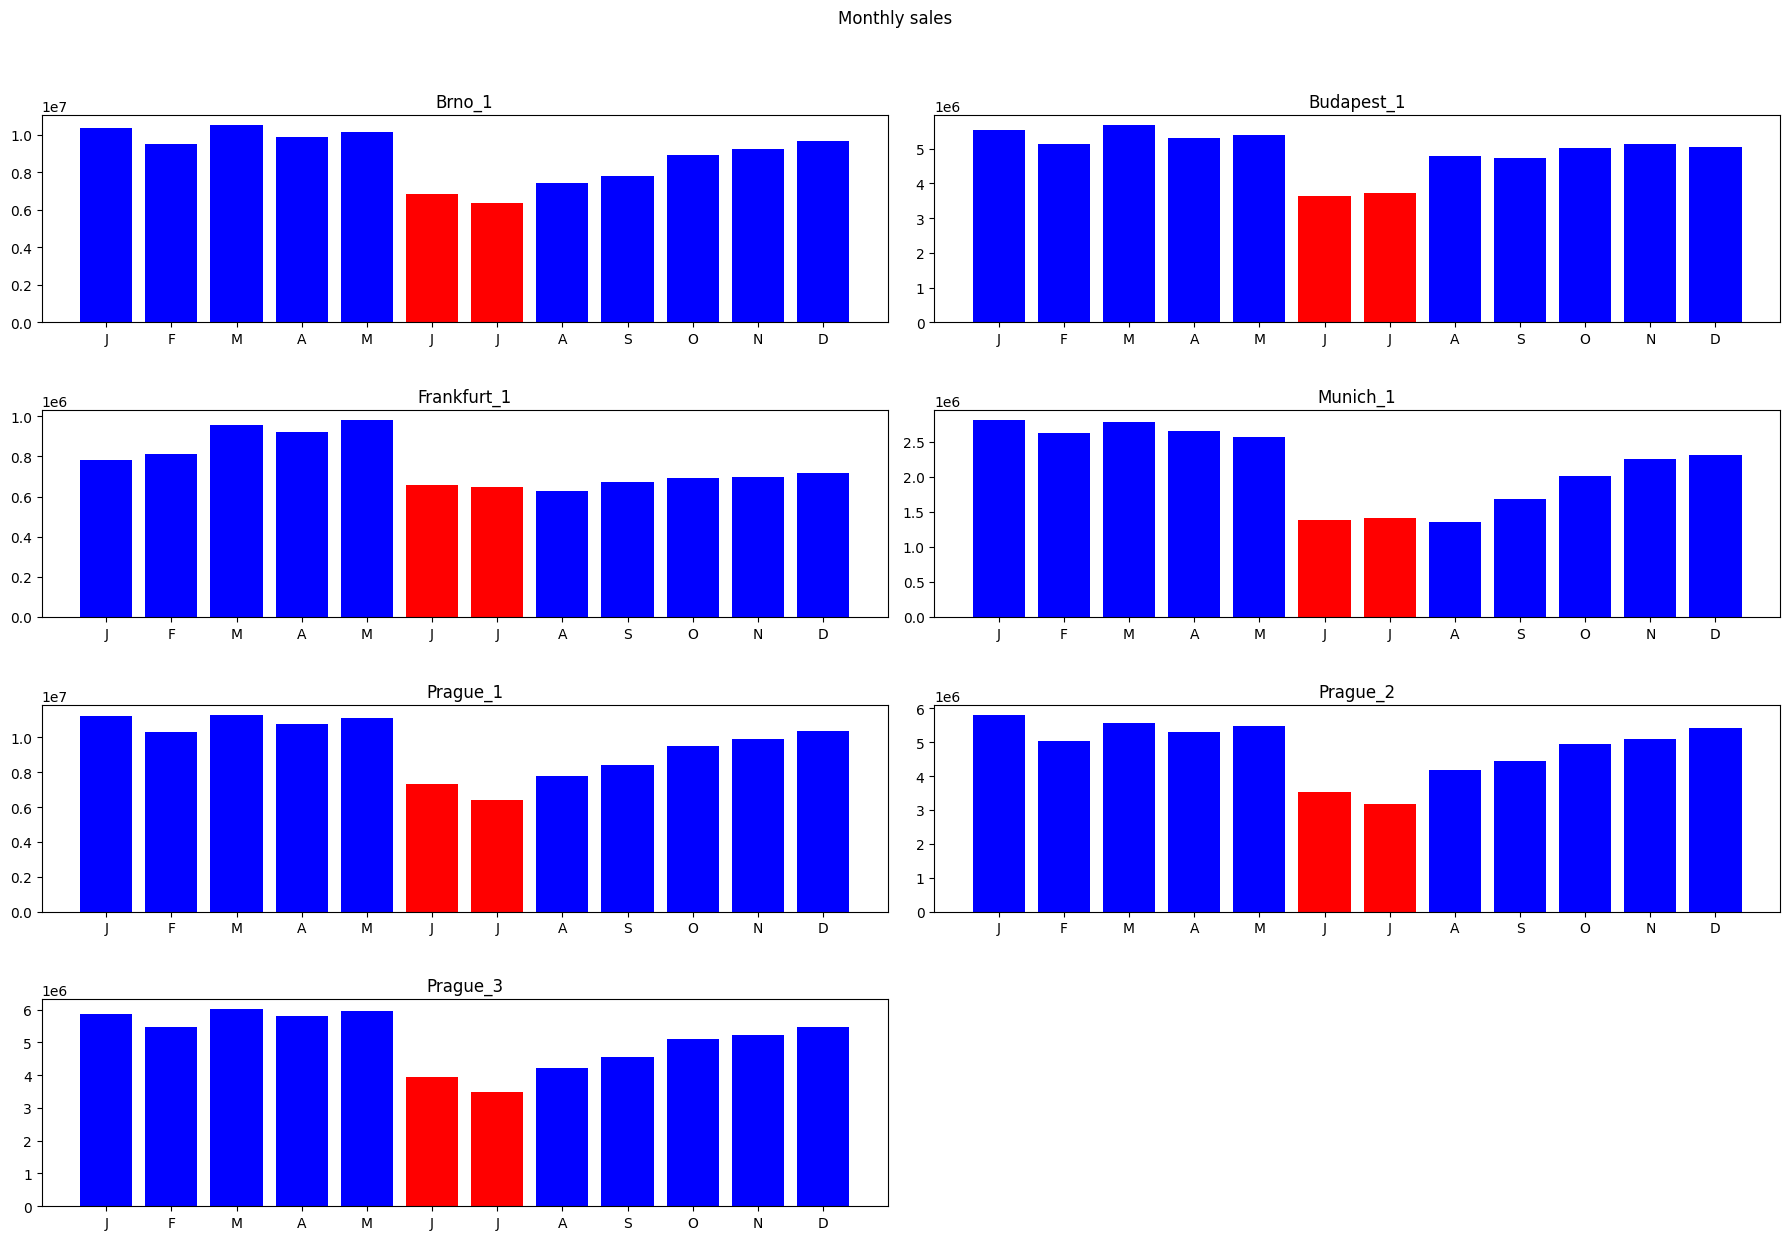

In [29]:
plt.figure(figsize=(18,12))
for i, (comb, df) in enumerate(sales_train.groupby('warehouse',observed=False)):
    ax = plt.subplot(4,2, i+1)
    resampled = df.sort_values(by='date').groupby(df.index.month)['sales'].sum()
    colors = ['b'] * 5 + ['r'] * 2 + ['b'] * 5
    ax.bar(range(1, 13), resampled, color= colors)
    ax.set_xticks(ticks=range(1, 13), labels='JFMAMJJASOND')
    ax.set_title(comb)


plt.suptitle('Monthly sales', y=1.03)
plt.tight_layout(h_pad=3.0)
plt.show()

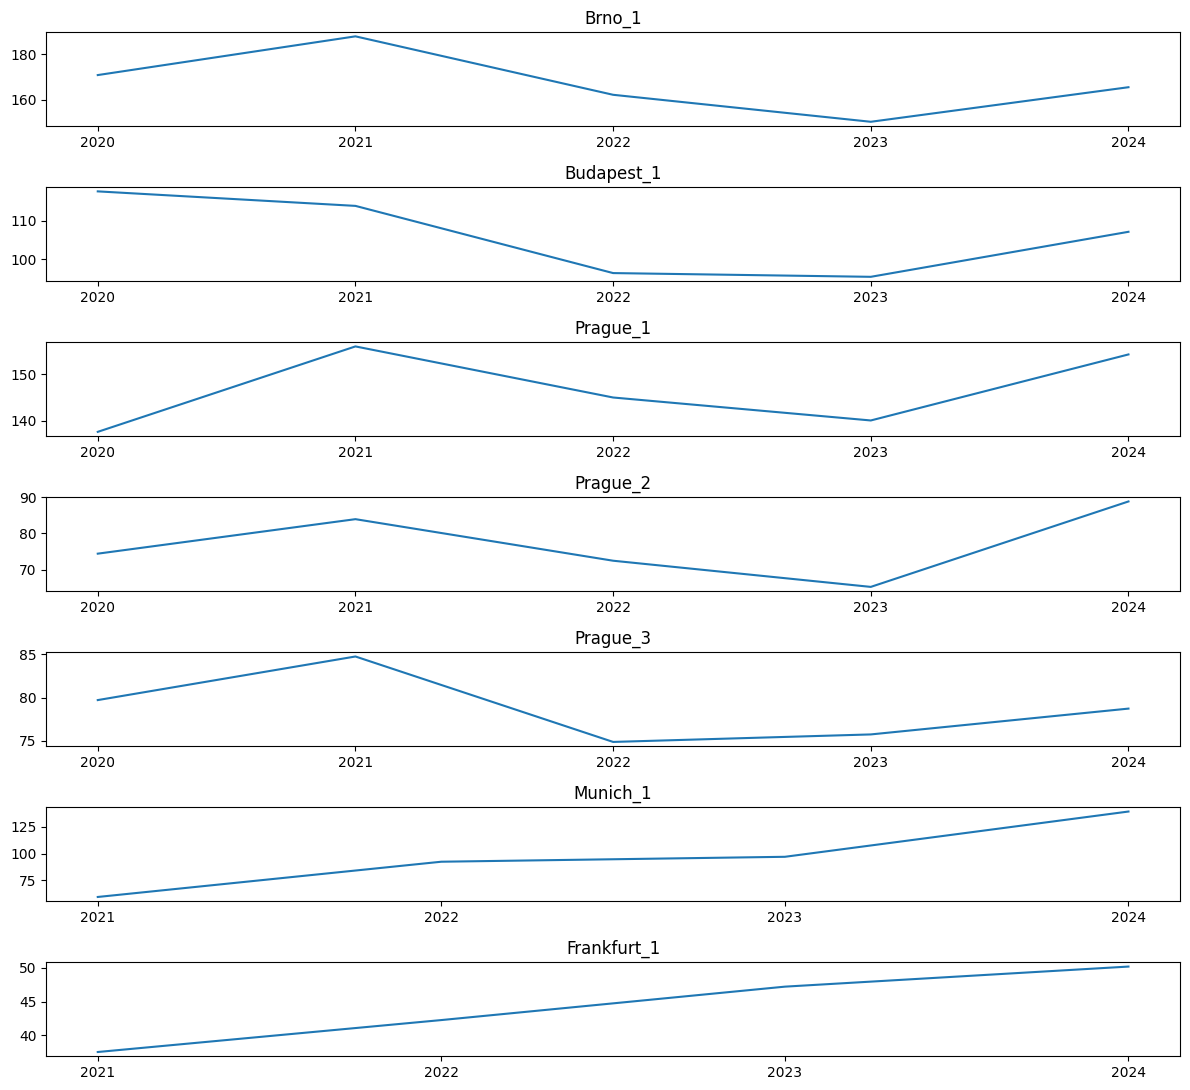

In [30]:
yearp = sales_train.groupby(['warehouse',sales_train.index.year],observed=True)['sales'].mean().reset_index()
plt.figure(figsize=(12,11))
for i,w in enumerate(u_warehouses):
    ax = plt.subplot(len(u_warehouses),1,i+1)
    ax.plot(yearp[yearp.warehouse==w]['date'],yearp[yearp.warehouse==w]['sales'])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(w)
plt.tight_layout()
plt.show()

In [31]:
sales_train.loc[sales_train.sales.isnull(),:].reset_index().groupby(['warehouse'],observed=False). \
agg(size=('warehouse','size'),
    min_date=('date','min'),
    max_date=('date','max'),
    days = ('date', lambda x: x.max() - x.min()),
    split_date=('date', lambda x: list(np.unique(np.unique(x.dt.strftime('%Y-%m-%d')))))
   ).dropna()

,size,min_date,max_date,days,split_date
warehouse,,,,,
Frankfurt_1,6,2021-12-09,2021-12-10,1 days,"[2021-12-09, 2021-12-10]"
Munich_1,46,2021-05-21,2021-07-11,51 days,"[2021-05-21, 2021-05-22, 2021-05-23, 2021-05-2..."


In [32]:
sales_train['sales'] = sales_train['sales'].fillna(0)
sales_train['total_orders'] = sales_train['total_orders'].fillna(0)
sales_train['sell_price_main'] = sales_train['sell_price_main'].interpolate()

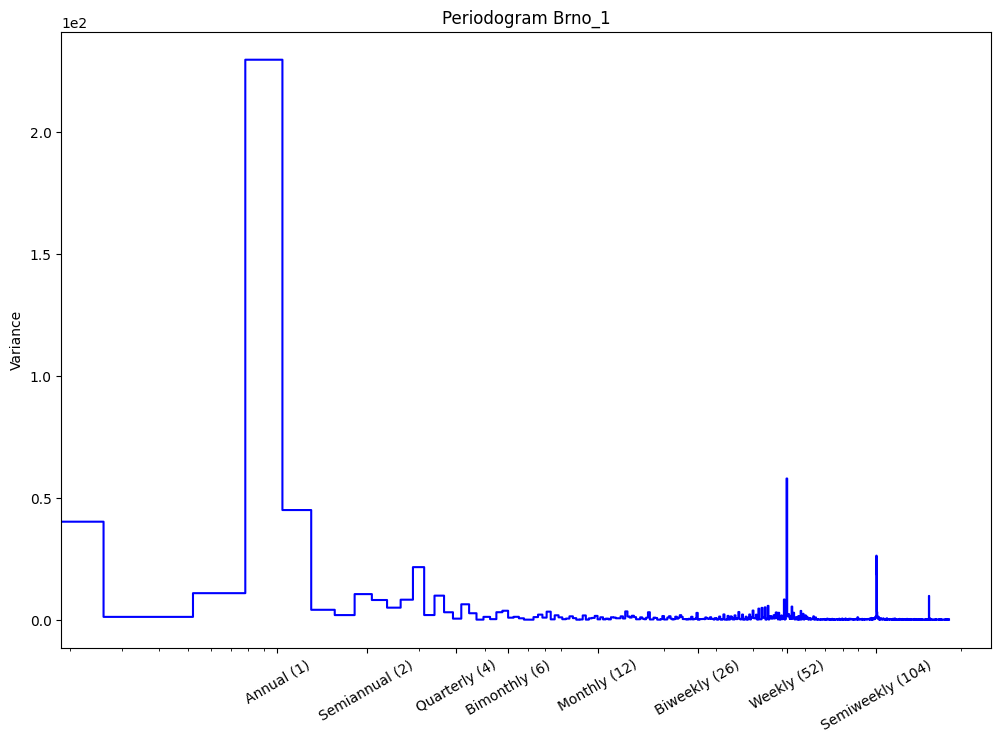

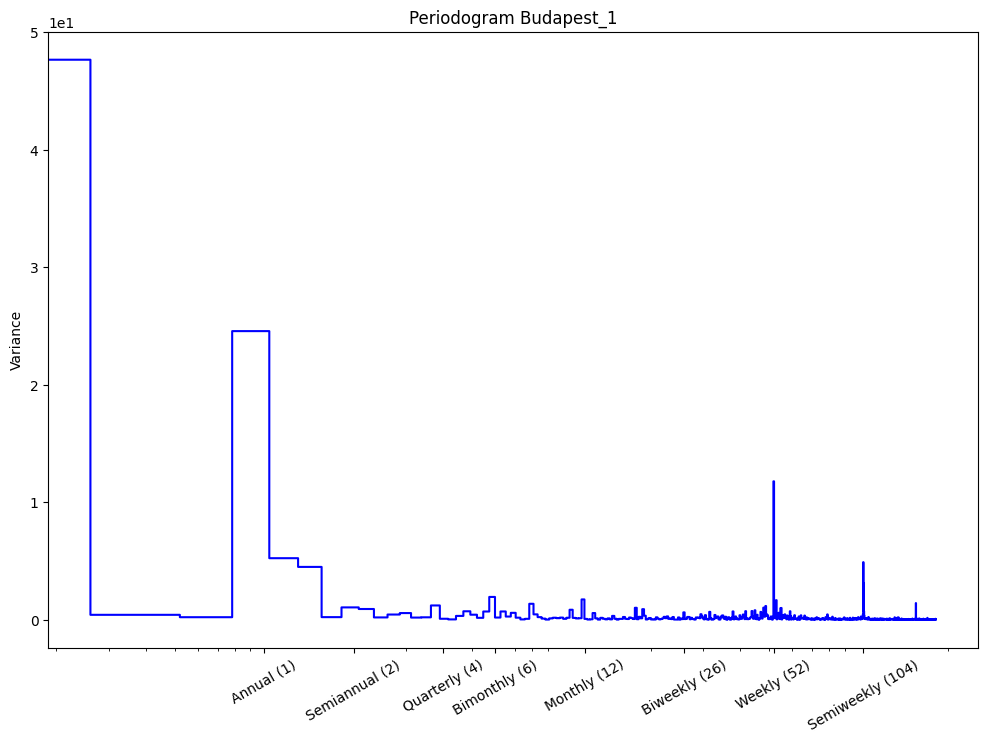

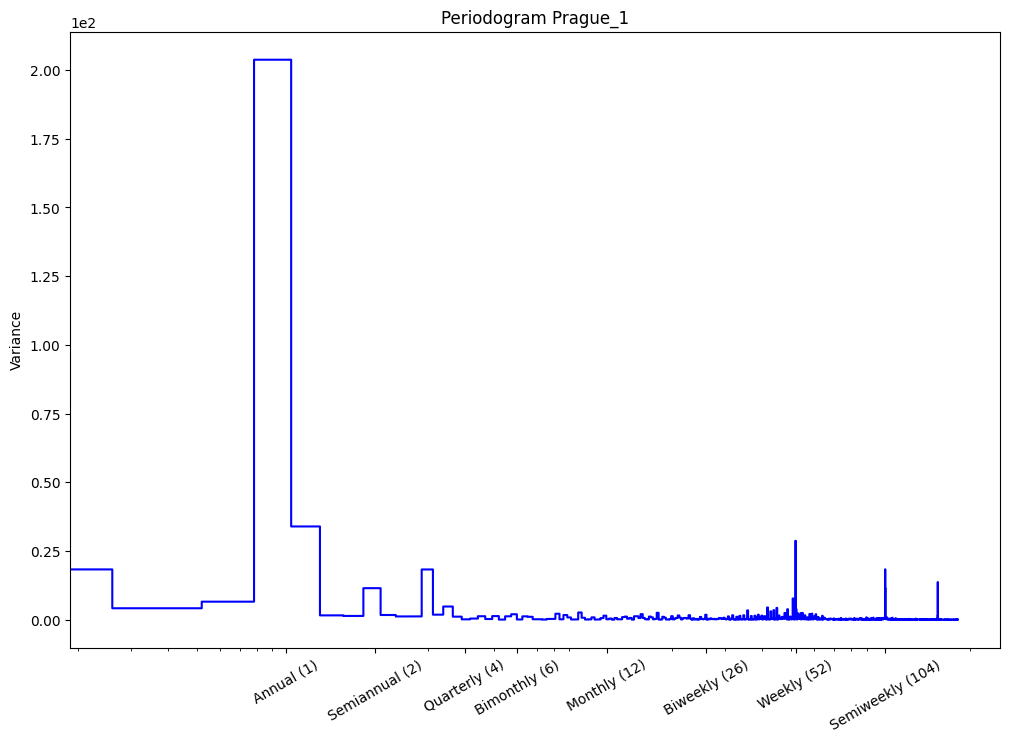

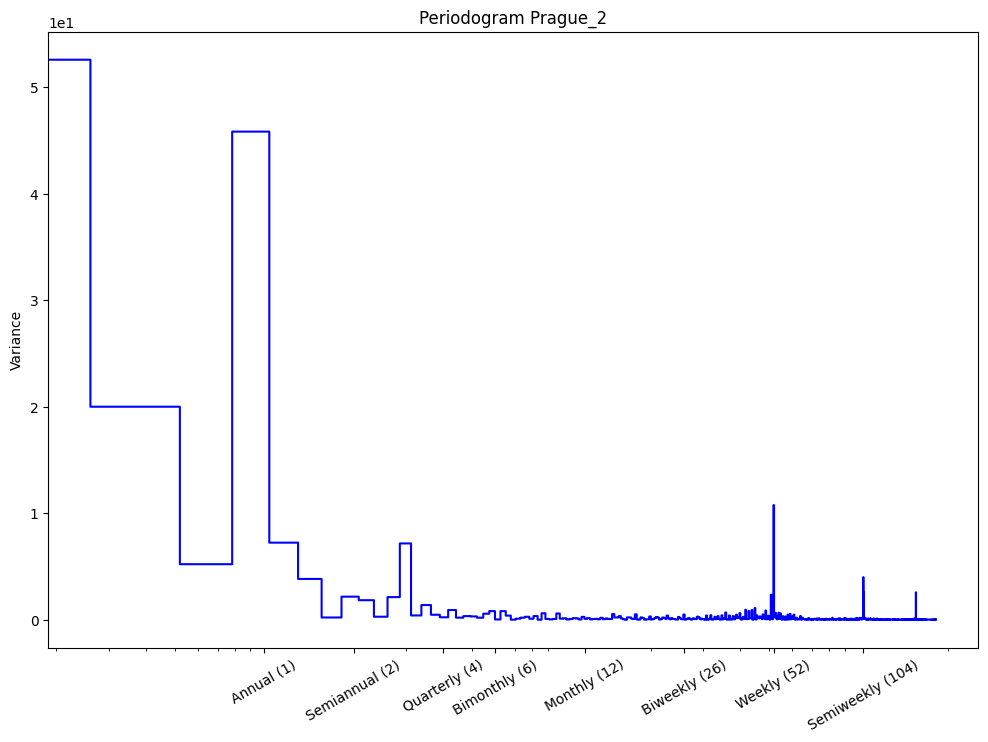

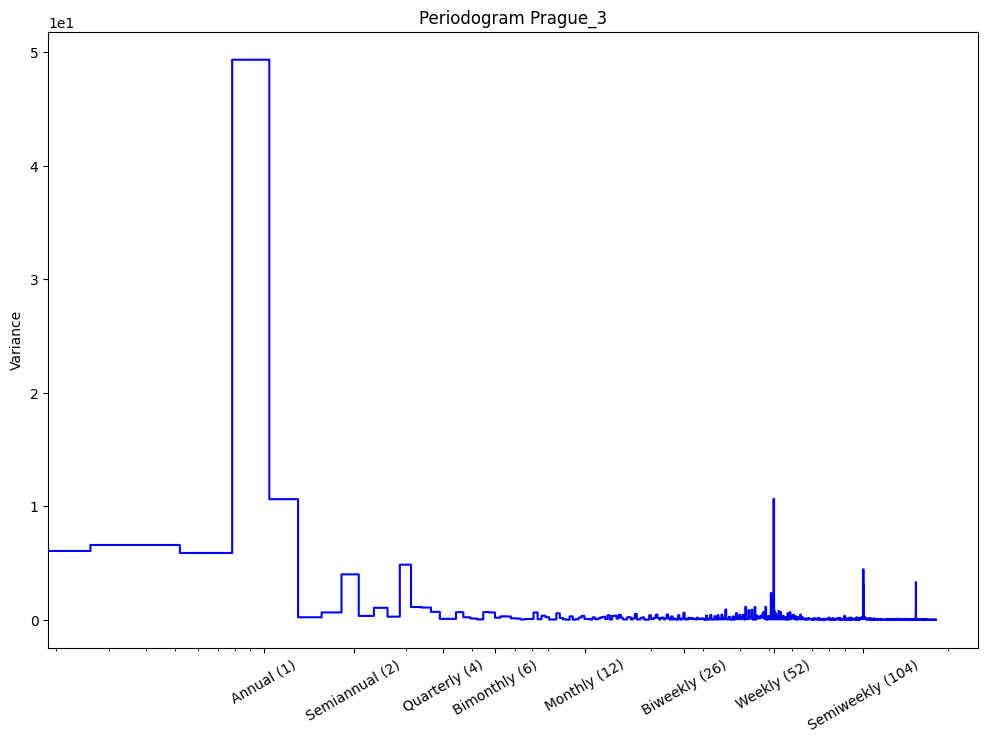

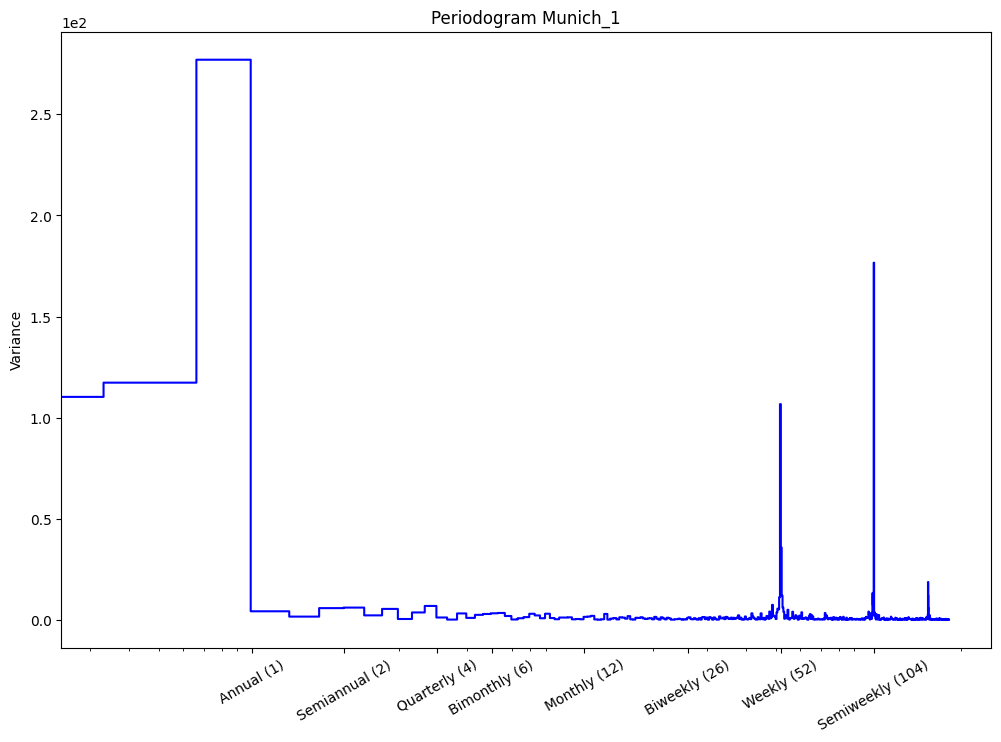

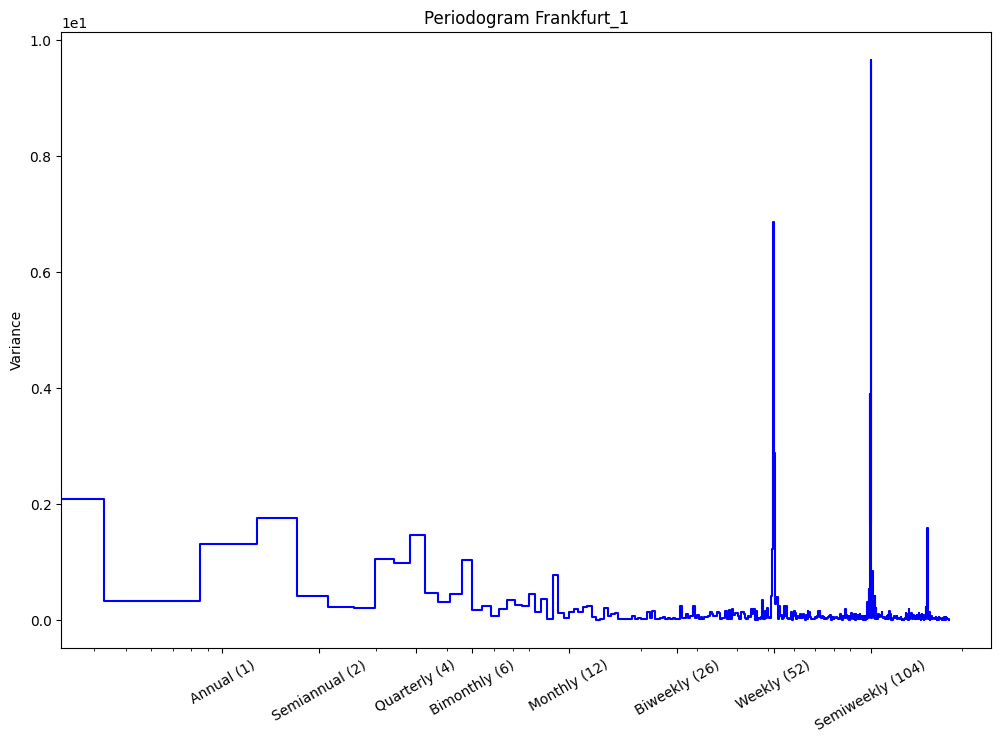

In [33]:
from scipy.signal import periodogram

def plot_periodogram(serie,wh,ax=None):
    fs = pd.Timedelta('365D') / pd.Timedelta('1D')
    freq, spec = periodogram(serie, fs=fs,detrend='linear',scaling='spectrum')

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    ax.step(freq, spec, color="blue")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title(f"Periodogram {wh}")

for u in u_warehouses:
    plot_periodogram(sales_train[sales_train.warehouse==u].groupby('date').sales.mean(),u)

In [34]:
weight_map = test_weights.set_index('unique_id')['weight'].to_dict()

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropColsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,cols):
        self.cols = cols

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        return X.drop(self.cols,axis=1)

In [36]:
class CreateTimeFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        df['year'] = df.index.year
        df['month'] = df.index.month
        df['weekday'] = df.index.weekday
        df['week'] = df.index.isocalendar().week
        df['weekend'] = df.index.weekday // 5
        df['semiweekly'] = np.where(df.index.weekday <3,0,1)
        df['year_sin'] = np.sin(df['year'] / 1 * 2 * np.pi)
        df['year_cos'] = np.cos(df['year'] / 1 * 2 * np.pi)
        df['month_sin'] = np.sin(df['month'] / 12 * 2 * np.pi)
        df['month_cos'] = np.cos(df['month'] / 12 * 2 * np.pi)

        return df

In [37]:
ctf = CreateTimeFeatures()
sales_train = ctf.fit_transform(sales_train).copy()
sales_test = ctf.fit_transform(sales_test).copy()

my_index = sales_train.index
my_index_ts = sales_test.index

agg_df = sales_train.reset_index().groupby(['name'],observed=False).agg(
    days_in_sale=('date','nunique'),
    purchase_interval=('date',lambda x: (x.max() - x.min()).days)
    ).reset_index()

sales_train = sales_train.merge(agg_df[['name', 'days_in_sale', 'purchase_interval']], on='name', how='left')
sales_test = sales_test.merge(agg_df[['name', 'days_in_sale', 'purchase_interval']], on='name', how='left')
sales_train.set_index(my_index, inplace=True)

In [38]:
sales_train.loc[:,'date_diff'] = sales_train.reset_index().groupby(
    'name',observed=False)['date'].diff().dt.days.fillna(0).reset_index()['date'].values
sales_train['gap'] = sales_train['date_diff'] > 1
sales_train['gap_group'] = sales_train.groupby(['name'],observed=False)['gap'].cumsum()
agg_df = sales_train.groupby(['name', 'gap_group'],observed=False)['date_diff'].max().reset_index()
agg_df = agg_df.groupby('name',observed=False)['date_diff'].max().rename('days_without_sale')
sales_train = sales_train.merge(agg_df, on='name', how='left')
sales_test = sales_test.merge(agg_df, on='name', how='left')

sales_train.set_index(my_index,inplace=True)
sales_test.set_index(my_index_ts,inplace=True)

In [39]:
oofs = {}
scores = {}
test_preds = {}
COMPUTE_TEST = True

In [40]:
from sklearn.base import clone
from sklearn.metrics import PredictionErrorDisplay, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline

def cross_validate(estimator, features, plot_residuals=False, fit_params={}):
    kf = TimeSeriesSplit(n_splits=5, test_size=dt.timedelta(weeks=2).days)
    X = sales_train[features].copy()
    y = sales_train[target]

    model = clone(estimator)
    val_preds = np.zeros(len(X))
    list_scores = []

    for fold, (trx_idx, val_idx) in enumerate(kf.split(X,y,groups=X['warehouse'])):
        X_train, y_train = X.iloc[trx_idx], y.iloc[trx_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model.fit(X_train.drop('unique_id',axis=1),y_train, **fit_params)
        y_pred = model.predict(X_val.drop('unique_id',axis=1)).clip(0,None)
        val_preds[val_idx] += y_pred
        wmape = mean_absolute_error(y_val,y_pred,sample_weight=X_val["unique_id"].map(weight_map).values)
        list_scores.append(wmape)

        print(f' #{fold} - wmae: {wmape}')
        if plot_residuals:
            display = PredictionErrorDisplay.from_predictions(y_val,y_pred)
            plt.show()
    if isinstance(model,Pipeline):
        name_model = type(model[-1]).__name__
    else:
        name_model = type(model).__name__


    oofs[name_model] = val_preds
    scores[name_model] = list_scores
    print(f'wmae mean: {np.mean(list_scores)}')

    if COMPUTE_TEST:
        print('Computing Test prediction....')
        model = clone(estimator)
        model.fit(X,y)

        test_pred = model.predict(sales_test[features]).clip(0,None)
        test_preds[name_model] = test_pred
        print('Computing Test prediction - Ok')

In [41]:
!pip install category-encoders
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.0 MB/s eta 0:00:00


In [44]:
cross_validate(make_pipeline(
    TargetEncoder(cols=['name',
                        'L2_category_name_en',
                        'L3_category_name_en',
                        'L4_category_name_en'
                        ]),
    OneHotEncoder(cols=['warehouse','L1_category_name_en']),
    StandardScaler(),
    Ridge()
    ), initial_features+['days_in_sale', 'purchase_interval', 'days_without_sale',
                         'year_sin','year_cos','month_sin','month_cos'])

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1213: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


 #0 - wmae: 38.79447152525331
 #1 - wmae: 54.22981853234118
 #2 - wmae: 31.01020715099019
 #3 - wmae: 51.01584041237584
 #4 - wmae: 85.18013292142524
wmae mean: 52.046094108477156
Computing Test prediction....
Computing Test prediction - Ok


In [46]:
from lightgbm import LGBMRegressor

cross_validate(make_pipeline(
    TargetEncoder(cols=['name', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en']),
    LGBMRegressor(verbosity=-1)),initial_features+['days_in_sale', 'purchase_interval',
                                                   'days_without_sale','year_sin','year_cos','week','weekday'])

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1213: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


 #0 - wmae: 21.116541579728498
 #1 - wmae: 25.8070686150989
 #2 - wmae: 24.1623189724565
 #3 - wmae: 31.82219472274763
 #4 - wmae: 38.14924590012285
wmae mean: 28.211473958030876
Computing Test prediction....
Computing Test prediction - Ok


In [48]:
from xgboost import XGBRegressor

cross_validate(make_pipeline(
             TargetEncoder(cols=['name',
                                 'L2_category_name_en',
                                 'L3_category_name_en',
                                 'L4_category_name_en']),
             XGBRegressor(verbosity=0,enable_categorical=True)),
             initial_features+['days_in_sale', 'purchase_interval'])

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1213: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


 #0 - wmae: 9.098550667461584
 #1 - wmae: 24.904129851069545
 #2 - wmae: 23.979148741060268
 #3 - wmae: 33.02785709595715
 #4 - wmae: 77.51700489041407
wmae mean: 33.70533824919253
Computing Test prediction....
Computing Test prediction - Ok


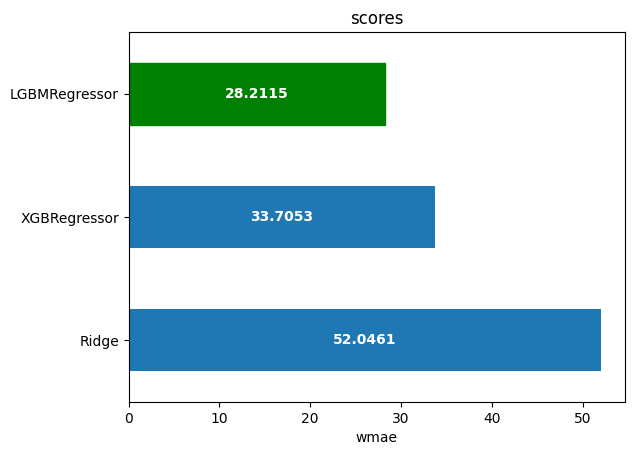

In [49]:
df_score = pd.DataFrame().from_dict(scores)
ax = df_score.mean().sort_values(ascending=False).plot(kind='barh')
bars = ax.patches
bars[-1].set_color('green')
ax.bar_label(ax.containers[0],label_type='center',color='white',fontweight='bold')
plt.title('scores')
ax.set_xlabel('wmae')
plt.show()